## Evaluate quality of prior for conjugate settings

1 [1 point]. Select a conjugate prior from list:

| #   | Likelihood     | Prior        |       
| :-- | :------------- |:-------------| 
| 1   | Bernoulli     | Beta  | 
| 2   | Binomial      | Beta  | 
| 3   | Negative Binomial      | Beta  | 
| 4   | Poisson       | Gamma | 
| 5   | Categorical   | Dirichlet | 
| 6   | Multinomial   | Dirichlet | 
| 7   | Geometric   | Beta | 
| 8   | Gaussian with known variance   | Gaussian | 
| 9   | Gaussian with known mean   | Inverse Gamma | 
| 10   | Gaussian with known mean   | Scaled Inverse Chi-Squared | 
| 11   | Gaussian with known mean   | Gamma | 
| 12   | Gaussian  | Gaussian-Inverse Gamma |
| 13   | Gaussian  | Gaussian-Gamma |
| 14   | Uniform   | Pareto | 
| 15   | Weibull with known shape   | Inverse Gamma | 
| 16   | Log-normal with known precision  | Gaussian | 
| 17   | Log-normal with known mean  | Gamma | 
| 18  | Exponential   | Gamma | 
| 19  | Gamma with known shape   | Gamma | 
| 20  | Inverse Gamma with known shape   | Gamma | 

See more information at
https://en.wikipedia.org/wiki/Conjugate_prior


2. [1 point] Code sampling from selected distribution giving parameters $p(x | \theta)$
3. [1 points] Write a procedure for MLE estimates for this distribution.
4. [2 points] Write a procedure for evaluation of posterior for selected model given selected prior and likelihood.
5. [2 points] Plot posteriors wrt sample size. Use analytical formulas.
6. [4 points] Compare quality of MLE estimate, MAP estimate and Bayesian estimate (mean value of a posterior) in terms of the squared loss $\sum_{i = 1}^n (\theta_i - \hat{\theta}_i)^2$ for each parameter separately w.r.t sample size. Plot your results. Use analytical formulas everywhere if possible. 

My number is 7 (Geometric and Beta).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import beta
import warnings
warnings.filterwarnings("ignore")

Let's define a class for a geometric distribution and related functions.

In [2]:
class GeomDist:
    
    def __init__(self, p):
        self.p = p
    
    def generate(self, size=1):
        '''
        Generating a dataset
        '''
        return np.random.geometric(self.p, size=size)
    
#     def get_prob_from_data(self, n):
#         '''
#         Given sample from distribution we try to estimate 
#         '''
#         p = self.p
#         q = 1 - self.p
#         prob = q ** (n - 1) * p
#         return prob
    
#     def get_likelihood_log(self, samples):
#         probs = gd.get_prob_from_data(samples)
#         probs_log = np.log(probs)
#         likelihood_log = probs_log.sum()
        
#         return likelihood_log
    
    def estimate_p_mle(self, samples):
        '''
        Estimation of $p$ for given data with MLE
        '''
        return 1 / samples.mean()
    
    def get_posterior_params(self, samples, prior_alpha=1, prior_beta=1):
        '''
        Bayes estimation of posterior.
        Returns parameters $alpha$ and $beta$ for posterior beta distribution.
        '''
        alpha = prior_alpha + len(samples)
        beta = prior_beta + samples.sum() - len(samples)
        return alpha, beta

Likelihood function $L(x_1, x_2, \dots, x_n| p) = p^m(1-p)^{(\sum_{i=1}^{m}x_i) - m}$

MLE estimation is $p = \frac{m}{\sum_{i=1}^{m}x_i} = \frac1{\overline{x}}$.

Prior distribution is B(1, 1), a.k.a. uniform distribution. Posterior is beta with parameters $\alpha = 1 + m, \beta = 1 + \sum_{i=1}^{m}x_i - m$.

We are considering sample size from $10$ to $10^6$.

Let $p=0.1$.

In [3]:
points_posterior_dict = {}
n_samples_list = [10 ** i for i in range(1, 7)]

In [4]:
actual_p = 0.1
gd = GeomDist(p=actual_p)

for n_samples in n_samples_list:
    samples = gd.generate(n_samples)
    alpha_posterior, beta_posterior = gd.get_posterior_params(samples)
    posterior = beta(alpha_posterior, beta_posterior)
    points_posterior_dict[n_samples] = posterior

In [5]:
points = np.linspace(0, 1, 1001)

Now we can draw posterior's PDF wrt sample size.

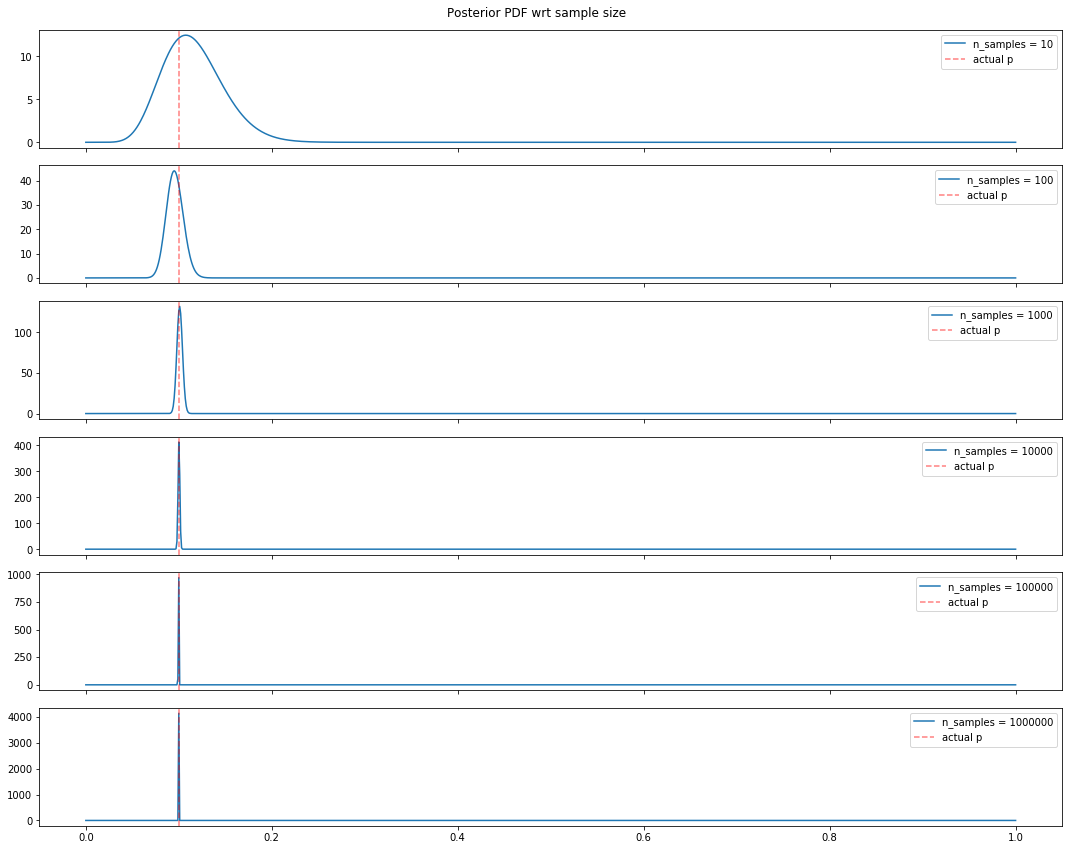

In [6]:
fig, ax = plt.subplots(len(points_posterior_dict), 1, sharex=True)
fig.set_figheight(12)
fig.set_figwidth(15)

for i, n_samples in enumerate(points_posterior_dict):
    posterior = points_posterior_dict[n_samples]
    pdfs = [posterior.pdf(point) for point in points]
    ax[i].plot(points, pdfs, label=f'n_samples = {n_samples}')
    ax[i].axvline(actual_p, alpha=0.5, linestyle='dashed', color='r', label='actual p')
    ax[i].legend()

fig.suptitle('Posterior PDF wrt sample size')
plt.tight_layout(rect=[0, 0, 1, 0.97])

Now we can compare MLE, MAP and Bayes estimations. In order to do that for each sample size we calculate estimation for p from 0.01 to 0.99 and consider MSE.

In [7]:
p_list = np.linspace(0.01, 0.99, 99)
n_samples_list = [2 ** i for i in range(1, 20)]

In [8]:
from collections import defaultdict
import pandas as pd
import xarray as xr

ModuleNotFoundError: No module named 'xarray'

In [ ]:
estimates = defaultdict(dict)

In [ ]:
for actual_p in p_list:
    for n_samples in n_samples_list:
        gd = GeomDist(p=actual_p)
        samples = gd.generate(n_samples)
        estimate_mle = gd.estimate_p_mle(samples) #  MLE estimation from samples
        alpha_posterior, beta_posterior = gd.get_posterior_params(samples)
#         posterior = beta(alpha_posterior, beta_posterior)
        estimate_bayes = alpha_posterior / (alpha_posterior + beta_posterior) #  Mean for beta distribution
        estimate_map = (alpha_posterior - 1) / (alpha_posterior + beta_posterior - 2) #  MAP for beta distribution
        
        estimations = {
            'bayes': estimate_bayes,
            'mle': estimate_mle,
            'map': estimate_map,
            'actual_p': actual_p,
        }
        
        estimates[actual_p][n_samples] = estimations

In [ ]:
xa = pd.Panel(estimates).to_xarray()

In [ ]:
methods_list = ['mle', 'map', 'bayes']
df_errors = ((xa.loc[:, methods_list, :] - xa.loc[:, 'actual_p', :]) ** 2).mean(axis=0).to_dataframe(name='error')

In [ ]:
df_errors;

In [ ]:
plt.figure(figsize=(15,10))
plt.yscale('log')
plt.xscale('log')
alpha=1
plt.plot(df_errors.loc['bayes'], label='Bayes', alpha=alpha, linestyle='solid', lw=3)
plt.plot(df_errors.loc['mle'], label='MLE', alpha=alpha, linestyle='--', lw=3, color='m')
plt.plot(df_errors.loc['map'], label='MAP', alpha=alpha, linestyle=':', lw=3, color='pink')
plt.legend()
plt.suptitle('MSE wrt sample size for different methods')
plt.ylabel('MSE')
plt.xlabel('Sample size')
plt.tight_layout(rect=[0, 0, 1, 0.97])

It's clear from the graph, that MLE and MAP estimations are identical. Bayes estimation is slightly better for small number of samples.